## ThorM: A Machine Learning Approach for Classifying Convective Storm Risk Levels Using Climatological Data in Metro Manila, Philippines

### Authors
- Kristina V. Celis
- Sean Alexander P. Porras
- Christian Justin J. Salinas


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
from collections import defaultdict
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from xgboost import XGBClassifier

Upload CSV to Google Colab from Drive (commented out for local copy run)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# Load the dataset
file_path = '/content/drive/Shared drives/ThorM/Google Colab/Datasets/Quezon-City-2020-10-01-to-2024-10-01.csv'
# data_raw = pd.read_csv(file_path)

# File paths
file_path = '/content/drive/Shared drives/ThorM/Google Colab/Datasets/Quezon-City-2020-10-01-to-2024-10-01.csv'
output_path = '/content/drive/Shared drives/ThorM/Google Colab/Datasets/EDA_dataset.csv'

# Load dataset
# data = pd.read_csv(file_path)

# Create a deep copy of the original data
# original_data = data.copy()

# Load dataset for local copy
data = pd.read_csv("Quezon-City-2020-10-01-to-2024-10-01.csv")
original_data = data.copy()

## DATASET OVERVIEW

In [4]:
# Check first few rows
print("First few rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("### Dataset Information ###")
data.info()

print("\n### Dataset Description ###")
print(data.describe())

# Check for missing values in the dataset
print("\n### Missing Values Summary ###")
print(data.isnull().sum())

# Summary statistics for the target column 'severerisk'
print("\n### Summary Statistics for 'severerisk' ###")
print(data['severerisk'].describe())

First few rows of the dataset:
          name   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  quezon city  10/1/2020     33.4     25.2  29.1          42.5          25.2   
1  quezon city  10/2/2020     32.9     25.2  28.4          40.6          25.2   
2  quezon city  10/3/2020     32.7     25.9  28.4          39.6          25.9   
3  quezon city  10/4/2020     33.9     26.1  28.8          40.3          26.1   
4  quezon city  10/5/2020     34.0     25.3  29.1          52.6          25.3   

   feelslike   dew  humidity  ...  solarenergy  uvindex  severerisk  \
0       34.3  25.1      80.1  ...         14.4        8         NaN   
1       32.1  24.6      80.6  ...         16.4        7         NaN   
2       32.4  24.9      82.2  ...         19.3        9         NaN   
3       33.2  24.8      80.0  ...         21.9        9         NaN   
4       33.8  24.6      77.3  ...         21.3        9         NaN   

               sunrise               sunset  moonphase 

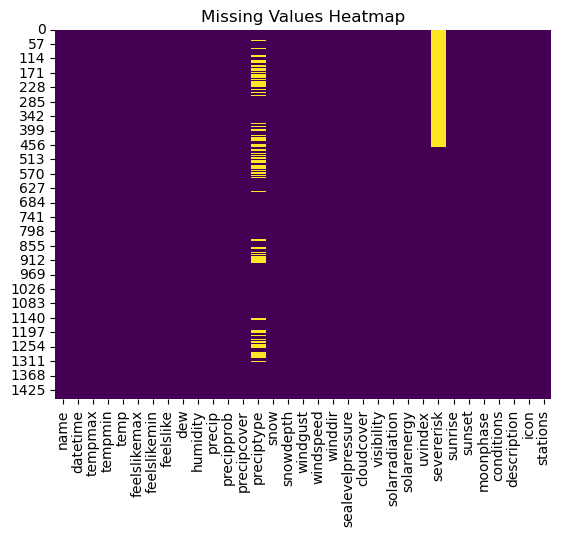


### Rows with Missing Values in 'severerisk' ###
            name   datetime  tempmax  tempmin  temp  feelslikemax  \
0    quezon city  10/1/2020     33.4     25.2  29.1          42.5   
1    quezon city  10/2/2020     32.9     25.2  28.4          40.6   
2    quezon city  10/3/2020     32.7     25.9  28.4          39.6   
3    quezon city  10/4/2020     33.9     26.1  28.8          40.3   
4    quezon city  10/5/2020     34.0     25.3  29.1          52.6   
..           ...        ...      ...      ...   ...           ...   
461  quezon city   1/5/2022     31.0     23.4  26.7          33.0   
462  quezon city   1/6/2022     28.9     23.2  26.3          32.1   
463  quezon city   1/7/2022     31.0     22.3  26.5          33.7   
464  quezon city   1/8/2022     31.0     23.1  26.9          35.5   
465  quezon city   1/9/2022     32.0     23.0  27.2          35.8   

     feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0            25.2       34.3  25.1      80.1  

In [5]:
# Visualize missing values with a heatmap
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Display rows with missing values in the target column 'severerisk'
print("\n### Rows with Missing Values in 'severerisk' ###")
print(data[data['severerisk'].isnull()])

## Handling Missing Values of 'severerisk' & 'preciptype'

In [6]:
data = data.dropna(subset=['severerisk'])
print(f"Shape after dropping rows with missing 'severerisk': {data.shape}")

data.loc[:, 'preciptype'] = data['preciptype'].fillna('None')
print(f"Shape after dropping rows with missing 'preciptype': {data.shape}")



Shape after dropping rows with missing 'severerisk': (996, 33)
Shape after dropping rows with missing 'preciptype': (996, 33)


## Distribution of Target Variable (severerisk)

Distribution of 'severerisk':
severerisk
10.0    457
30.0    394
60.0    140
75.0      5
Name: count, dtype: int64


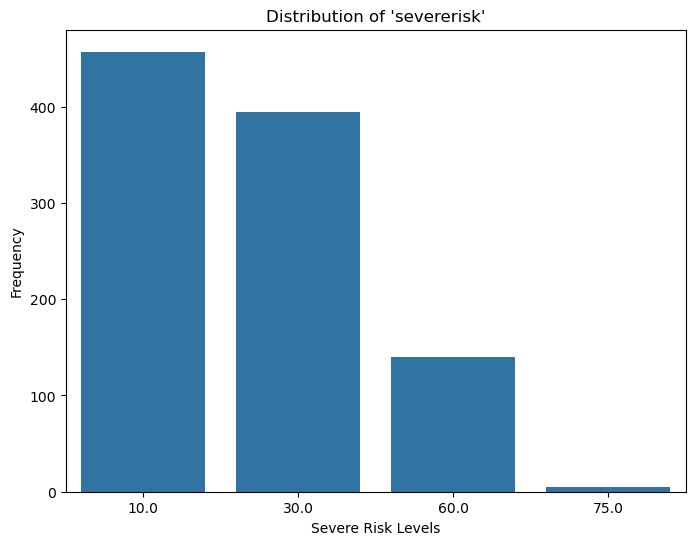

In [7]:
# Distribution of severerisk
print("Distribution of 'severerisk':")
print(data['severerisk'].value_counts())

# Plot distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='severerisk')
plt.title("Distribution of 'severerisk'")
plt.xlabel("Severe Risk Levels")
plt.ylabel("Frequency")
plt.show()

## Target Encoding

In [8]:
# Define risk thresholds and directly map to numerical values
def encode_severerisk(value):
    if value < 30:
        return 0  # Low
    elif 30 <= value < 70:
        return 1  # Moderate
    else:
        return 2  # High

# Apply the encoding
data['severerisk_encoded'] = data['severerisk'].apply(encode_severerisk)

# Drop the original 'severerisk' column
data = data.drop(columns=['severerisk'], errors='ignore')

# Verify the encoding
print(data['severerisk_encoded'].value_counts())


severerisk_encoded
1    534
0    457
2      5
Name: count, dtype: int64


## Process Non-numerical and Irrelevant Features

In [9]:
# List of irrelevant features to drop
irrelevant_features = ['name', 'description', 'icon', 'stations', 'snow', 'snowdepth']

# Drop irrelevant features
data = data.drop(columns=irrelevant_features, errors='ignore')

# Confirm the remaining features
print("Features After Dropping Irrelevant Ones:")
print(data.columns)

print("\nDataset Info After Dropping Irrelevant Features:")
print(data.info())

Features After Dropping Irrelevant Ones:
Index(['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase',
       'conditions', 'severerisk_encoded'],
      dtype='object')

Dataset Info After Dropping Irrelevant Features:
<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 466 to 1461
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            996 non-null    object 
 1   tempmax             996 non-null    float64
 2   tempmin             996 non-null    float64
 3   temp                996 non-null    float64
 4   feelslikemax        996 non-null    float64
 5   feelslikemin        996 non-null    

In [10]:
# Identify non-numerical features
non_numerical_features = data.select_dtypes(include=['object', 'category']).columns
print("Non-Numerical Features:", non_numerical_features)


Non-Numerical Features: Index(['datetime', 'preciptype', 'sunrise', 'sunset', 'conditions'], dtype='object')


In [11]:
# Convert 'datetime' to pandas datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the month
data['month'] = data['datetime'].dt.month

# Encode 'month' cyclically
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Drop unnecessary columns
data = data.drop(columns=['datetime', 'month'], errors='ignore')

# Confirm the changes
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 466 to 1461
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempmax             996 non-null    float64
 1   tempmin             996 non-null    float64
 2   temp                996 non-null    float64
 3   feelslikemax        996 non-null    float64
 4   feelslikemin        996 non-null    float64
 5   feelslike           996 non-null    float64
 6   dew                 996 non-null    float64
 7   humidity            996 non-null    float64
 8   precip              996 non-null    float64
 9   precipprob          996 non-null    int64  
 10  precipcover         996 non-null    float64
 11  preciptype          996 non-null    object 
 12  windgust            996 non-null    float64
 13  windspeed           996 non-null    float64
 14  winddir             996 non-null    float64
 15  sealevelpressure    996 non-null    float64
 16  cloudcover

In [12]:
# Encode as binary
data['preciptype'] = data['preciptype'].apply(lambda x: 1 if x == 'rain' else 0)
print(data['preciptype'].value_counts())


preciptype
1    770
0    226
Name: count, dtype: int64


In [13]:
# Convert to datetime type
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# Calculate daylight hours
data['daylight_hours'] = (data['sunset'] - data['sunrise']).dt.total_seconds() / 3600

# Drop original columns
data = data.drop(columns=['sunrise', 'sunset'], errors='ignore')

In [14]:
# One-Hot Encoding of 'conditions'
le = LabelEncoder()
data = pd.get_dummies(data, columns=['conditions'], drop_first=True)

In [15]:
print("\nDataset Info After Converting Non-Numerical Features:")
print(data.info())

# Identify any remaining non-numerical features
non_numerical_features = data.select_dtypes(include=['object', 'category']).columns
print("Remaining Non-Numerical Features:", non_numerical_features)


Dataset Info After Converting Non-Numerical Features:
<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 466 to 1461
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tempmax                            996 non-null    float64
 1   tempmin                            996 non-null    float64
 2   temp                               996 non-null    float64
 3   feelslikemax                       996 non-null    float64
 4   feelslikemin                       996 non-null    float64
 5   feelslike                          996 non-null    float64
 6   dew                                996 non-null    float64
 7   humidity                           996 non-null    float64
 8   precip                             996 non-null    float64
 9   precipprob                         996 non-null    int64  
 10  precipcover                        996 non-null    float64
 11  preci

## Check Correlations/Relationships

In [16]:
# Compute correlation matrix
correlation_matrix = data.corr()

# Identify features highly correlated with 'severerisk'
high_corr_features = correlation_matrix['severerisk_encoded'].abs().sort_values(ascending=False)
print("Highly Correlated Features with 'severerisk':\n", high_corr_features)

Highly Correlated Features with 'severerisk':
 severerisk_encoded                   1.000000
dew                                  0.734210
month_sin                            0.584156
feelslike                            0.553896
feelslikemax                         0.553450
daylight_hours                       0.537627
tempmin                              0.512797
humidity                             0.493915
sealevelpressure                     0.469815
month_cos                            0.464033
winddir                              0.455672
preciptype                           0.436333
feelslikemin                         0.428393
precipprob                           0.426362
conditions_Partially cloudy          0.424399
conditions_Rain, Partially cloudy    0.380817
precipcover                          0.347199
temp                                 0.332665
cloudcover                           0.270703
visibility                           0.261564
precip                           

## Drop redundant features

In [17]:
# Check pairwise correlations among temp-related features
temp_corr = data[['temp', 'tempmin', 'tempmax']].corr()
print(temp_corr)


             temp  tempmin   tempmax
temp     1.000000  0.66745  0.881533
tempmin  0.667450  1.00000  0.396630
tempmax  0.881533  0.39663  1.000000


In [18]:
# Correlation between feelslike-related features
feelslike_corr = data[['feelslike', 'feelslikemax', 'feelslikemin']].corr()
print(feelslike_corr)

              feelslike  feelslikemax  feelslikemin
feelslike      1.000000      0.906567      0.729251
feelslikemax   0.906567      1.000000      0.568987
feelslikemin   0.729251      0.568987      1.000000


In [19]:
redundant_features = ['temp', 'feelslikemin', 'feelslikemax', 'tempmax']
data = data.drop(columns=redundant_features, errors='ignore')

## Checking for Skewness

In [20]:
# Identify numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

# Exclude categorical and target features
categorical_features = ['conditions_Partially cloudy',
                        'conditions_Rain, Overcast',
                        'conditions_Rain, Partially cloudy',
                        'preciptype',
                        'severerisk_encoded']

# Filter numerical features
numerical_features_to_check = [col for col in numerical_features if col not in categorical_features]

In [21]:
# Calculate skewness for numerical features
skewness = data[numerical_features_to_check].skew().sort_values(ascending=False)

# Identify heavily skewed features (|skewness| > 1)
heavily_skewed = skewness[abs(skewness) > 1].index
print("Heavily skewed numerical features:", heavily_skewed)

print("Skewness before transformation:")
print(data[heavily_skewed].skew())

Heavily skewed numerical features: Index(['precip', 'windgust', 'windspeed'], dtype='object')
Skewness before transformation:
precip       8.005226
windgust     6.792879
windspeed    4.112155
dtype: float64


In [22]:
# Use PowerTransformer (Yeo-Johnson, works with zeros/negatives)
pt = PowerTransformer(method='yeo-johnson')  # Handles zeros and negatives
data[heavily_skewed] = pt.fit_transform(data[heavily_skewed])

# Recheck skewness
print("Skewness after transformation:")
print(data[heavily_skewed].skew())

Skewness after transformation:
precip       0.554764
windgust    -0.010749
windspeed   -0.036305
dtype: float64


In [23]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 466 to 1461
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tempmin                            996 non-null    float64
 1   feelslike                          996 non-null    float64
 2   dew                                996 non-null    float64
 3   humidity                           996 non-null    float64
 4   precip                             996 non-null    float64
 5   precipprob                         996 non-null    int64  
 6   precipcover                        996 non-null    float64
 7   preciptype                         996 non-null    int64  
 8   windgust                           996 non-null    float64
 9   windspeed                          996 non-null    float64
 10  winddir                            996 non-null    float64
 11  sealevelpressure                   996 non-null    float64
 

## Checking for Outliers

In [24]:
# Calculate IQR
Q1 = data[numerical_features_to_check].quantile(0.25)
Q3 = data[numerical_features_to_check].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = ((data[numerical_features_to_check] < lower_bound) |
            (data[numerical_features_to_check] > upper_bound))

# Count outliers for each feature
outliers_count = outliers.sum()
print("Outliers detected in each feature:")
print(outliers_count)


Outliers detected in each feature:
tempmin              32
feelslike             0
dew                   4
humidity              0
precip                0
precipprob            0
precipcover          11
windgust              7
windspeed            12
winddir               0
sealevelpressure     34
cloudcover            0
visibility          127
solarradiation        2
solarenergy           2
uvindex              12
moonphase             0
month_sin             0
month_cos             0
daylight_hours        0
dtype: int64


In [25]:
# Meaningful features (keep as is)
features_to_keep = ['tempmin', 'visibility', 'windgust', 'windspeed']

# Features to handle (all numerical features with outliers minus the ones to keep)
features_to_handle = [col for col in numerical_features_to_check if col not in features_to_keep]

# Cap outliers to IQR bounds
for col in features_to_handle:
    data[col] = data[col].clip(lower=lower_bound[col], upper=upper_bound[col])

print("Outliers handled for features:", features_to_handle)

Outliers handled for features: ['feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase', 'month_sin', 'month_cos', 'daylight_hours']


## Review Original vs. Preprocessed Features

In [26]:
# Count the number of original features
original_feature_count = original_data.shape[1]
print(f"Original Feature Count: {original_feature_count}")

# Count the number of preprocessed features
preprocessed_feature_count = data.shape[1]
print(f"Preprocessed Feature Count: {preprocessed_feature_count}")

# List original and preprocessed features
original_features = original_data.columns.tolist()
preprocessed_features = data.columns.tolist()

print("\nList of Original Features:")
print(original_features)

print("\nList of Preprocessed Features:")
print(preprocessed_features)

# Compare features
added_features = set(preprocessed_features) - set(original_features)
removed_features = set(original_features) - set(preprocessed_features)

print(f"\nAdded Features ({len(added_features)}): {added_features}")
print(f"Removed Features ({len(removed_features)}): {removed_features}")

Original Feature Count: 33
Preprocessed Feature Count: 25

List of Original Features:
['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']

List of Preprocessed Features:
['tempmin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase', 'severerisk_encoded', 'month_sin', 'month_cos', 'daylight_hours', 'conditions_Partially cloudy', 'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy']

Added Features (7): {'month_cos', 'conditions_Rain, Overcast', 'mo

## Split dataset into Train and Test using Stratified Sampling

In [27]:
# Define features (X) and target (y)
X = data.drop(columns=['severerisk_encoded'])  # Drop the target column
y = data['severerisk_encoded']  # Target column

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% test set
    random_state=42,  # Ensure reproducibility
    stratify=y  # Maintain class proportions
)

# Check the distribution in the splits
print("Class distribution in the original dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in the training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in the test set:")
print(y_test.value_counts(normalize=True))


Class distribution in the original dataset:
severerisk_encoded
1    0.536145
0    0.458835
2    0.005020
Name: proportion, dtype: float64

Class distribution in the training set:
severerisk_encoded
1    0.536432
0    0.458543
2    0.005025
Name: proportion, dtype: float64

Class distribution in the test set:
severerisk_encoded
1    0.535
0    0.460
2    0.005
Name: proportion, dtype: float64


## Applying SMOTE

Apply SMOTE to oversample the minority classes in the training set.

In [28]:
# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Check the distribution of the training set after SMOTE
print("Class distribution in the training set before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution in the training set after SMOTE:")
print(y_train_smote.value_counts())

# Check the distribution in the test set (unchanged)
print("\nClass distribution in the test set:")
print(y_test.value_counts())

Class distribution in the training set before SMOTE:
severerisk_encoded
1    427
0    365
2      4
Name: count, dtype: int64

Class distribution in the training set after SMOTE:
severerisk_encoded
1    427
2    427
0    365
Name: count, dtype: int64

Class distribution in the test set:
severerisk_encoded
1    107
0     92
2      1
Name: count, dtype: int64


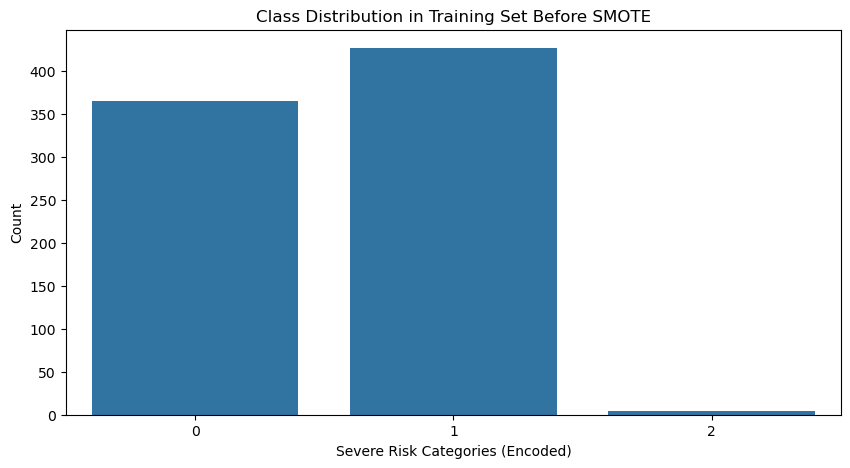

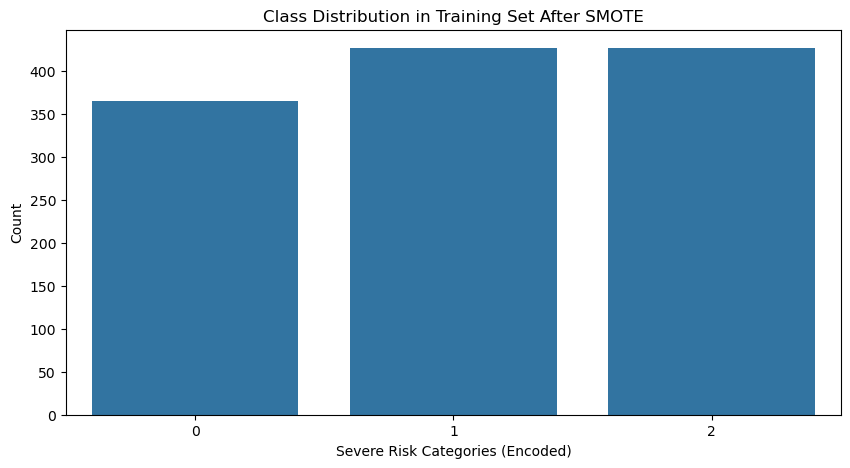

In [29]:
# Before SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set Before SMOTE")
plt.xlabel("Severe Risk Categories (Encoded)")
plt.ylabel("Count")
plt.show()

# After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_smote)
plt.title("Class Distribution in Training Set After SMOTE")
plt.xlabel("Severe Risk Categories (Encoded)")
plt.ylabel("Count")
plt.show()

## Feature Scaling

In [30]:
# Initialize scaler
scaler = StandardScaler()

# Scale training and test sets w/ SMOTE
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Scale training sets w/o SMOTE
X_train_scaled = scaler.fit_transform(X_train)

# Convert back to DataFrame for easier analysis
X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled, columns=X_train.columns)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Initialization of Classification Models

In [31]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42,eval_metric='mlogloss')
}

## Functions for evaluating classification models with and without RFE

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_baseline(models, X_train, y_train, X_test, y_test, smote=False):
    results = {}
    best_model_name = None
    best_model_metrics = None
    best_model = None
    highest_accuracy = 0

    print(f"Evaluating models without RFE (all features)...{' Using SMOTE' if smote else ''}")

    for name, model in models.items():
        # Train and test the model using all features
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
            "recall": recall_score(y_test, y_pred, average="weighted"),
            "f1_score": f1_score(y_test, y_pred, average="weighted")
        }
        results[name] = metrics

        # Check if this model is the best based on accuracy
        if metrics["accuracy"] > highest_accuracy:
            highest_accuracy = metrics["accuracy"]
            best_model_name = name
            best_model_metrics = metrics
            best_model = model

    # Display results
    print("\nBaseline Results (Without RFE):")
    for name, metrics in results.items():
        print(f"\n{name}:")
        for metric, value in metrics.items():
            print(f"  {metric.capitalize()}: {value:.4f}")

    print("\nBest Model Based on Accuracy:")
    print(f"  Model Name: {best_model_name}")
    for metric, value in best_model_metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

    # Display confusion matrix for the best model
    if best_model:
        y_pred_best = best_model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_best)

        # Define custom labels for confusion matrix
        labels = ['low', 'moderate', 'high']


        # Plot the confusion matrix with title
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(8, 6))  # Specify the figure size
        disp.plot(ax=ax)

        # Set the title of the plot
        ax.set_title(f'Confusion Matrix for {best_model_name}{" with SMOTE" if smote else " without SMOTE"}')
        plt.show()

    return results, best_model_name, best_model_metrics

def evaluate_rfe(model, model_name, X_train, y_train, X_test, y_test):
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

    total_features = X_train.shape[1]
    best_accuracy = 0
    best_no_features = 0
    best_features = []
    best_feature_importances = {}
    best_model = None

    print(f"\nEvaluating RFE for Model: {model_name}")

    for no_features in range(total_features, 0, -1):
        rfe = RFE(estimator=model, n_features_to_select=no_features)
        rfe.fit(X_train, y_train)

        # Transform datasets
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)

        # Train and evaluate the model
        model.fit(X_train_rfe, y_train)
        y_pred_rfe = model.predict(X_test_rfe)
        accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

        # Check if this is the best configuration
        if accuracy_rfe > best_accuracy:
            best_accuracy = accuracy_rfe
            best_no_features = no_features
            best_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]

            # Capture feature importance scores for selected features
            if hasattr(model, "feature_importances_"):  # For tree-based models
                importance_scores = model.feature_importances_
                best_feature_importances = {feature: score for feature, score in zip(best_features, importance_scores)}
            elif hasattr(model, "coef_"):  # For linear models
                importance_scores = abs(model.coef_[0]) if model.coef_.ndim > 1 else abs(model.coef_)
                best_feature_importances = {feature: score for feature, score in zip(best_features, importance_scores)}

            best_model = model

    # Display results
    print(f"\nModel: {model_name}")
    print(f"Best Number of Features: {best_no_features}")
    print(f"Accuracy with Best Features: {best_accuracy:.4f}")
    print(f"Selected Features with Importance Scores: {best_feature_importances}")

    # Display confusion matrix for the model with the best number of features
    if best_model:
        X_test_rfe_best = rfe.transform(X_test)
        y_pred_best = best_model.predict(X_test_rfe_best)
        cm = confusion_matrix(y_test, y_pred_best)
        print(f"\nConfusion Matrix for {model_name} with Best Features:")

        # Define custom labels for confusion matrix
        labels = ['low', 'moderate', 'high']

        # Plot the confusion matrix with title
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(8, 6))  # Specify the figure size
        disp.plot(ax=ax)

        # Set the title of the plot
        ax.set_title(f'Confusion Matrix for {model_name} with Best Features')
        plt.show()

    return best_no_features, best_features, best_feature_importances, best_accuracy


## Evaluating Classification Models

For data without SMOTE
Evaluating models without RFE (all features)...

Baseline Results (Without RFE):

Random Forest:
  Accuracy: 0.8350
  Precision: 0.8348
  Recall: 0.8350
  F1_score: 0.8330

Decision Tree:
  Accuracy: 0.7700
  Precision: 0.7782
  Recall: 0.7700
  F1_score: 0.7675

SVM:
  Accuracy: 0.8300
  Precision: 0.8366
  Recall: 0.8300
  F1_score: 0.8276

KNN:
  Accuracy: 0.8300
  Precision: 0.8306
  Recall: 0.8300
  F1_score: 0.8280

XGBoost:
  Accuracy: 0.8600
  Precision: 0.8623
  Recall: 0.8600
  F1_score: 0.8578

Best Model Based on Accuracy:
  Model Name: XGBoost
  Accuracy: 0.8600
  Precision: 0.8623
  Recall: 0.8600
  F1_score: 0.8578


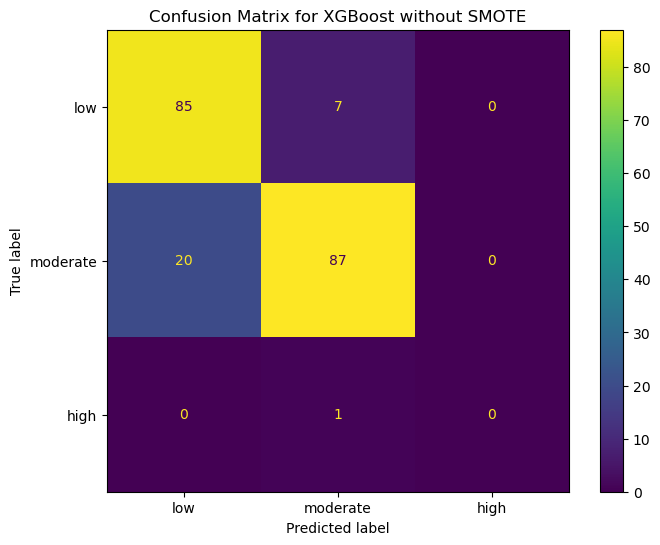


For data with SMOTE
Evaluating models without RFE (all features)... Using SMOTE

Baseline Results (Without RFE):

Random Forest:
  Accuracy: 0.8800
  Precision: 0.8773
  Recall: 0.8800
  F1_score: 0.8774

Decision Tree:
  Accuracy: 0.8350
  Precision: 0.8311
  Recall: 0.8350
  F1_score: 0.8326

SVM:
  Accuracy: 0.8550
  Precision: 0.8603
  Recall: 0.8550
  F1_score: 0.8570

KNN:
  Accuracy: 0.8000
  Precision: 0.8255
  Recall: 0.8000
  F1_score: 0.8123

XGBoost:
  Accuracy: 0.8600
  Precision: 0.8571
  Recall: 0.8600
  F1_score: 0.8574

Best Model Based on Accuracy:
  Model Name: Random Forest
  Accuracy: 0.8800
  Precision: 0.8773
  Recall: 0.8800
  F1_score: 0.8774


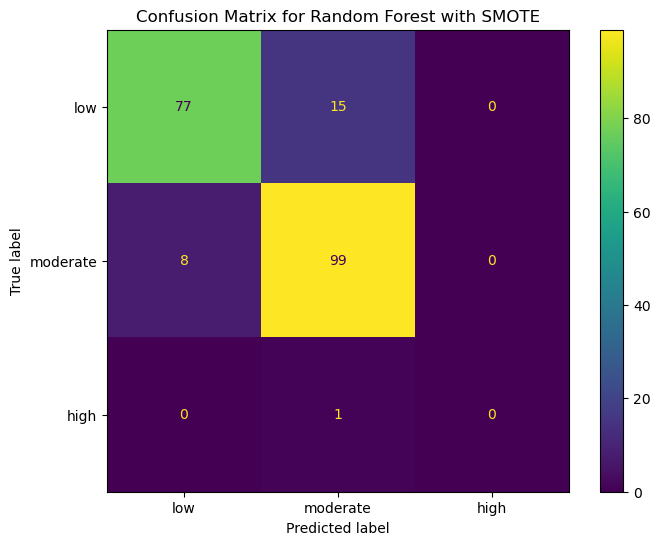

The best model was trained with SMOTE: Random Forest
Accuracy: 0.8800


In [33]:
print("For data without SMOTE")
# Evaluates classification model using dataset without SMOTE
baseline_results_no_smote, best_model_name_no_smote, best_model_metrics_no_smote = evaluate_baseline(
    models, X_train_scaled, y_train, X_test_scaled, y_test
)

print("\nFor data with SMOTE")
# Evaluates classification model using dataset with SMOTE
baseline_results_smote, best_model_name_smote, best_model_metrics_smote = evaluate_baseline(
    models, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test, smote=True
)


# Compare the accuracies of the best models
if best_model_metrics_no_smote["accuracy"] > best_model_metrics_smote["accuracy"]:
    baseline_results = baseline_results_no_smote
    best_model_name = best_model_name_no_smote
    best_model_metrics = best_model_metrics_no_smote
    print(f"The best model was trained without SMOTE: {best_model_name}")
    print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")
else:
    baseline_results = baseline_results_smote
    best_model_name = best_model_name_smote
    best_model_metrics = best_model_metrics_smote
    print(f"The best model was trained with SMOTE: {best_model_name}")
    print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")

## Evaluating Classification Models with RFE


Evaluating RFE for Model: Random Forest

Model: Random Forest
Best Number of Features: 10
Accuracy with Best Features: 0.8850
Selected Features with Importance Scores: {'tempmin': 0.06556747549750971, 'feelslike': 0.18616690626164167, 'dew': 0.2195941204043949, 'humidity': 0.08078690399754151, 'precip': 0.06471991377477343, 'precipcover': 0.07226516279892839, 'sealevelpressure': 0.04511784482698719, 'month_sin': 0.09935162073288258, 'month_cos': 0.055537098098704926, 'daylight_hours': 0.11089295360663556}

Confusion Matrix for Random Forest with Best Features:


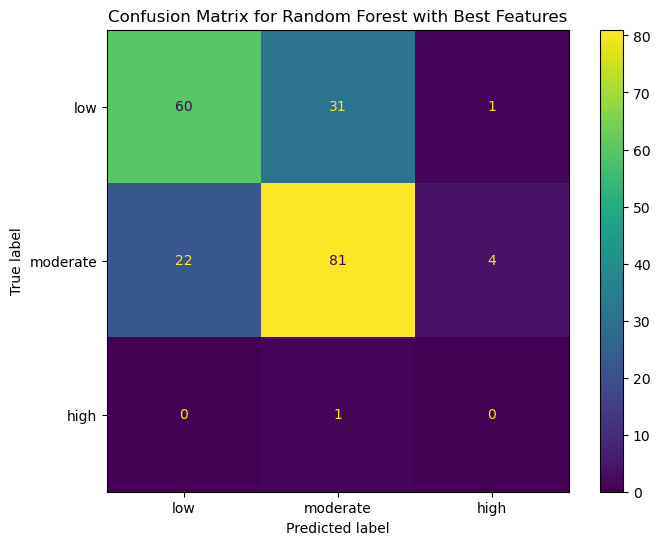

In [34]:
best_no_features, selected_features, selected_feature_importances, best_accuracy = evaluate_rfe(
    models[best_model_name], best_model_name, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test
)

## Hyperparameter Tuning
Identifying best hyperparameter for each model
(commented out because we already have the optimal hyperparameters)

In [35]:
# Hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 4]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 4]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
        "metric": ['minkowski', 'euclidean']
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}

# Perform hyperparameter tuning using GridSearchCV
best_estimators = {}

print("\nPerforming Hyperparameter Tuning...")

for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_smote_scaled, y_train_smote)

    # Save the best estimator
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best models on the test set
print("\nEvaluating Best Models on Test Set...")

for name, model in best_estimators.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Test Accuracy: {accuracy:.4f}")



Performing Hyperparameter Tuning...

Tuning hyperparameters for Random Forest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated accuracy: 0.9368

Tuning hyperparameters for Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validated accuracy: 0.9057

Tuning hyperparameters for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated accuracy: 0.9278

Tuning hyperparameters for KNN...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for KNN: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validated accuracy: 0.9032

Tuning hyperparame

## Initializing Models with Tuned Hyperparameters

In [36]:
# Hyperparameter Tuned Models
models_hyper_tuned = {
    "Random Forest": RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=10 ),
    "SVM": SVC(kernel='linear', random_state=42, gamma="scale", C=10),
    "KNN": KNeighborsClassifier(metric='minkowski', n_neighbors=5,weights="distance"),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss', colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8)
}

## Evaluating Hyperparameter Tuned Classification Models

--- Using Hyperparameter Tuned Classification Models ---
For data without SMOTE
Evaluating models without RFE (all features)...

Baseline Results (Without RFE):

Random Forest:
  Accuracy: 0.8300
  Precision: 0.8291
  Recall: 0.8300
  F1_score: 0.8280

Decision Tree:
  Accuracy: 0.7800
  Precision: 0.7861
  Recall: 0.7800
  F1_score: 0.7777

SVM:
  Accuracy: 0.8300
  Precision: 0.8343
  Recall: 0.8300
  F1_score: 0.8278

KNN:
  Accuracy: 0.8300
  Precision: 0.8306
  Recall: 0.8300
  F1_score: 0.8280

XGBoost:
  Accuracy: 0.8450
  Precision: 0.8448
  Recall: 0.8450
  F1_score: 0.8430

Best Model Based on Accuracy:
  Model Name: XGBoost
  Accuracy: 0.8450
  Precision: 0.8448
  Recall: 0.8450
  F1_score: 0.8430


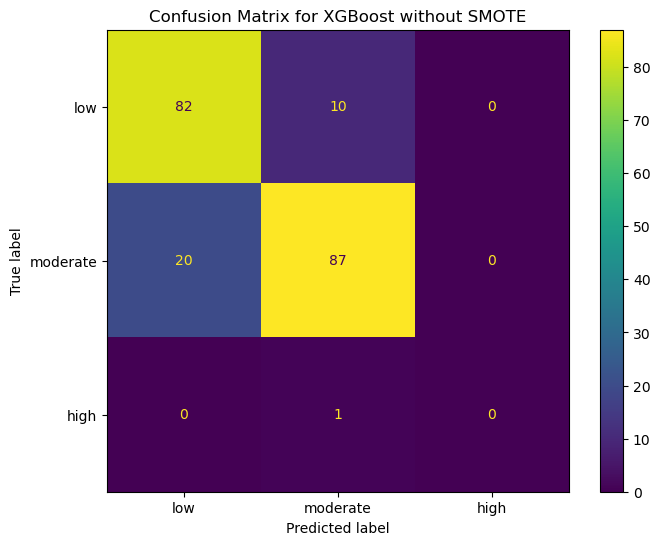


For data with SMOTE
Evaluating models without RFE (all features)... Using SMOTE

Baseline Results (Without RFE):

Random Forest:
  Accuracy: 0.8650
  Precision: 0.8627
  Recall: 0.8650
  F1_score: 0.8623

Decision Tree:
  Accuracy: 0.8350
  Precision: 0.8362
  Recall: 0.8350
  F1_score: 0.8345

SVM:
  Accuracy: 0.8500
  Precision: 0.8605
  Recall: 0.8500
  F1_score: 0.8541

KNN:
  Accuracy: 0.8050
  Precision: 0.8310
  Recall: 0.8050
  F1_score: 0.8174

XGBoost:
  Accuracy: 0.8750
  Precision: 0.8741
  Recall: 0.8750
  F1_score: 0.8721

Best Model Based on Accuracy:
  Model Name: XGBoost
  Accuracy: 0.8750
  Precision: 0.8741
  Recall: 0.8750
  F1_score: 0.8721


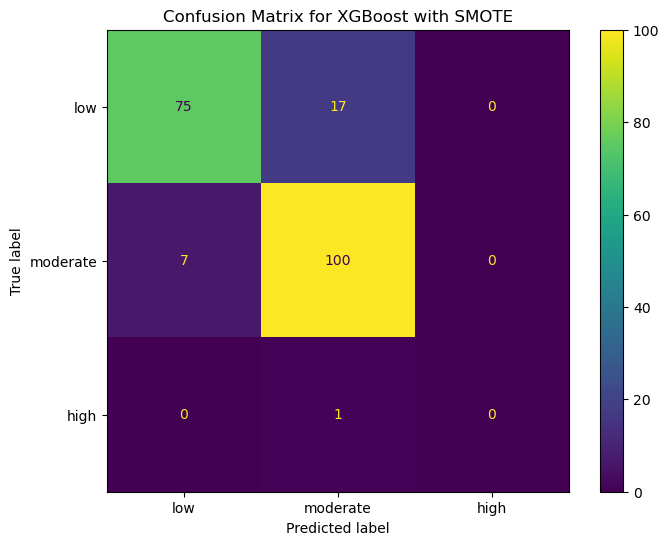

The best model was trained with SMOTE: XGBoost
Accuracy: 0.8750


In [37]:
print('--- Using Hyperparameter Tuned Classification Models ---')
print("For data without SMOTE")
# Evaluates hyperparameter tuned classification model using dataset without SMOTE
baseline_results_no_smote, best_model_name_no_smote, best_model_metrics_no_smote = evaluate_baseline(
    models_hyper_tuned, X_train_scaled, y_train, X_test_scaled, y_test
)

print("\nFor data with SMOTE")
# Evaluates hyperparameter tuned classification model using dataset with SMOTE
baseline_results_smote, best_model_name_smote, best_model_metrics_smote = evaluate_baseline(
    models_hyper_tuned, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test, smote=True
)

# Compare the accuracies of the best models
if best_model_metrics_no_smote["accuracy"] > best_model_metrics_smote["accuracy"]:
    baseline_results = baseline_results_no_smote
    best_model_name = best_model_name_no_smote
    best_model_metrics = best_model_metrics_no_smote
    print(f"The best model was trained without SMOTE: {best_model_name}")
    print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")
else:
    baseline_results = baseline_results_smote
    best_model_name = best_model_name_smote
    best_model_metrics = best_model_metrics_smote
    print(f"The best model was trained with SMOTE: {best_model_name}")
    print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")

## Evaluating Hyperparameter Tuned Classification Models with RFE


Evaluating RFE for Model: XGBoost

Model: XGBoost
Best Number of Features: 19
Accuracy with Best Features: 0.8900
Selected Features with Importance Scores: {'tempmin': 0.023141792, 'feelslike': 0.13852261, 'dew': 0.1133081, 'humidity': 0.047616098, 'precip': 0.05299959, 'precipprob': 0.12824851, 'precipcover': 0.082659155, 'windgust': 0.018897805, 'windspeed': 0.016690673, 'winddir': 0.013792287, 'sealevelpressure': 0.018142272, 'cloudcover': 0.020571383, 'visibility': 0.013230527, 'solarradiation': 0.014509254, 'solarenergy': 0.015433878, 'uvindex': 0.010273061, 'month_sin': 0.09604357, 'month_cos': 0.049710866, 'daylight_hours': 0.12620859}

Confusion Matrix for XGBoost with Best Features:


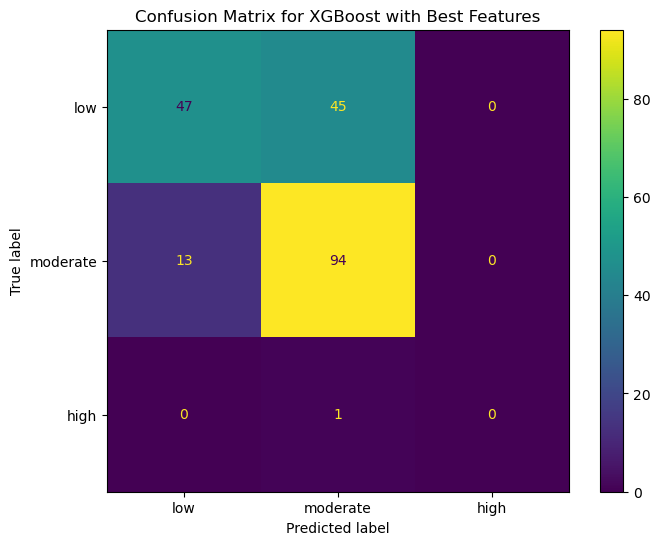

In [38]:
best_no_features, selected_features, selected_feature_importances, best_accuracy = evaluate_rfe(
    models_hyper_tuned[best_model_name], best_model_name, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test
)